<a href="https://colab.research.google.com/github/msa1997/ads-2023/blob/main/ADS_HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
import numpy as np

In [2]:
# Diable warnings about max_itr not reached etc.!
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#Dataset

The Fashion MNIST dataset is a large freely available database of fashion images. It contains 70,000 28x28 grayscale images of fashion products from 10 categories from a dataset of Zalando article images, with 7,000 images per category. The training set consists of 60,000 images and the test set consists of 10,000 images.

Each training and test example is assigned to one of the following labels:

Label	Description
* 0	T-shirt/top
* 1	Trouser
* 2	Pullover
* 3	Dress
* 4	Coat
* 5	Sandal
* 6	Shirt
* 7	Sneaker
* 8	Bag
* 9	Ankle boot

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train,y_train),(X_test,y_test) = fashion_mnist.load_data()
print(f'size of training set: {X_train.shape}')
print(f'size of test set: {X_test.shape}')

4422102/4422102 [==============================] - 0s 0us/step
size of training set: (60000, 28, 28)
size of test set: (10000, 28, 28)


As it is ususal in training pipeline, we set aside the test set intact, and train and evalute model using training set. In the other words the validation set comes from training set as well.

Now let's take a look at sample images.

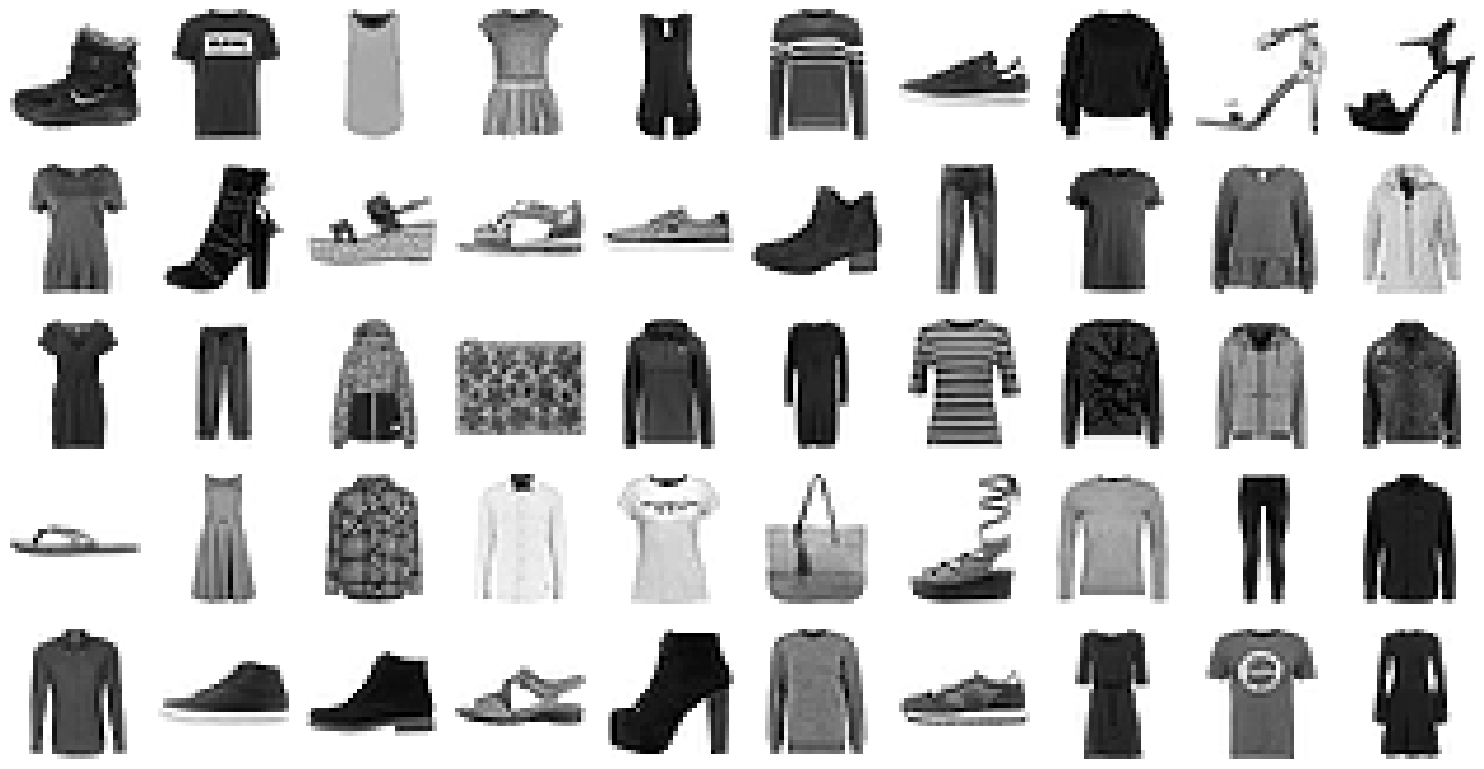

In [4]:

plt.figure(figsize=(15,8))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap='binary')
    plt.axis("off")
plt.tight_layout()

In [5]:
class_names = ["T-shirt/top" , "Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

Text(0.5, 1.0, 'Distributaion of the training set over all classes')

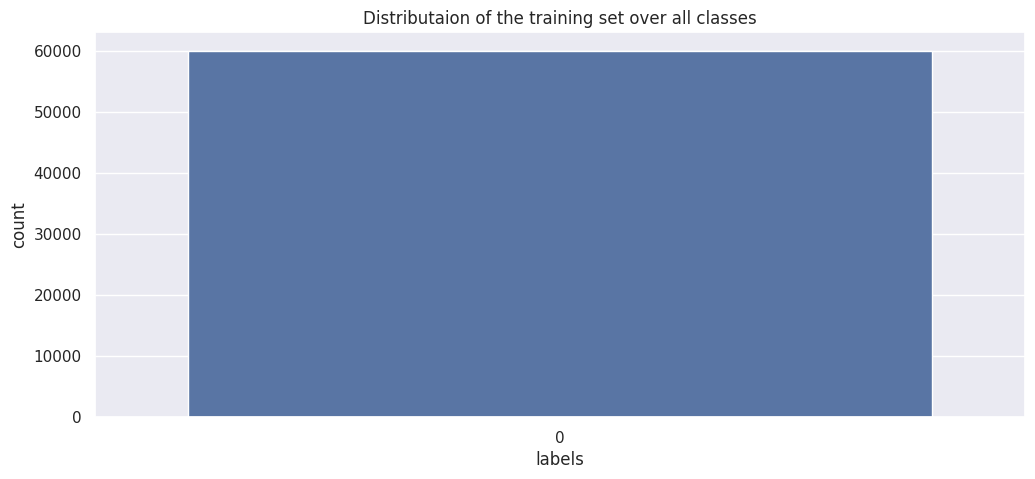

In [6]:
plt.figure(figsize=(12,5))
g = sns.countplot(y_train)
plt.xlabel('labels')
plt.title('Distributaion of the training set over all classes')

As you can see and as menstioned earlier, all classes have almost equal amount of samples.

Since we want to use Keras  API for this homework and the keras models need to receive labels in one-hot-encoding format we do so in cell below.

In [7]:
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
enc = LabelBinarizer()
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

In [8]:
y_train.shape

(60000, 10)

#Wrappers

In [9]:
# Importing necessary libraries
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras import callbacks
import tensorflow as tf
from keras import initializers
from keras.regularizers import l2,l1,l1_l2
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score



Since we are supposed to tune tons of hyperparameters!! and this way, a lots of codes should be duplicated over and over again, we use the wrapper functions introduced at lab sessions one for K-fold and one for creating models.

##Model Creation Wrapper

create a multi-layered feedforward neural network. The way it works is that we specify the following inputs:

*   no_hidden_neurons: this is a list of neurons in the hidden layers. The number of hidden layers is the length of this list.
*   input_size: the number of neurons in the input layer. It is equal to `X_train.shape[1]`
*   activation_func: it is a string specifying the type of the activation function.
*   l1_reg: a real number, which specifies the l1-regualirization coefficient in each layer (the higher it is, the more severe the regularization will be).
*   l2_reg: a real number, which specifies the l2-regualirization coefficient in each layer (the higher it is, the more severe the regularization will be).
*   learning_rate: a real number, specifying the learning rate in the gradient descent algorithm
*   learning_rate_decay: a real number, specifying the decay in the learning rate after a few iterations
*   dropout_rate: the rate at which neurons are "dropped-out" during training. If this value is 0, it means we won't have any dropout
*   weight_initializer: name of the weight initialization technique used to setup the weights when the algorithm starts.
    
Once given these inputs, the function creates the model according to our specs, compile it and return it as the output.

In [10]:
def create_model(no_hidden_neurons: list=[10], input_size=X_train.shape[1:],
                 activation_func: str='relu', l1_reg: float=0.0, l2_reg: float=0.0,
                 learning_rate: float=0.001, learning_rate_decay: float=0.95,
                 dropout_rate: float=0.0,weight_initializer: str='',
                 optimizer_name: str='adam',regularization_type: str='kernel'):

  # Setup the weight initialization techniques
  if weight_initializer == 'RandomNormal':
    weight_initializer = initializers.RandomNormal()
  elif weight_initializer == 'RandomUniform':
    weight_initializer = initializers.RandomUniform()
  elif weight_initializer == 'Zeros':
    weight_initializer = initializers.Zeros()
  elif weight_initializer == 'GlorotUniform':
    weight_initializer = initializers.GlorotUniform()
  elif weight_initializer == 'GlorotNormal':
    weight_initializer = initializers.GlorotNormal()
  else:
    weight_initializer = None

  model = Sequential()
  #we add layers later on




  #since our input is image in first place we should flatten it to be compatibale with the architecture of the MLP models
  model.add(keras.layers.Flatten(input_shape=input_size))



  # Add hidden layers
  itr = 0
  for n_l in no_hidden_neurons:
      # Add regularization
      if l1_reg and l2_reg:
        if regularization_type == 'activation':
          model.add(Dense(n_l, activation=activation_func,activity_regularizer=l1_l2(l1=l1_reg,l2=l2_reg),kernel_initializer=weight_initializer))
        else:
          model.add(Dense(n_l, activation=activation_func,kernel_regularizer=l1_l2(l1=l1_reg,l2=l2_reg),kernel_initializer=weight_initializer))
      elif l1_reg:
        if regularization_type == 'activation':
          model.add(Dense(n_l, activation=activation_func,activity_regularizer=l1(l1_reg),kernel_initializer=weight_initializer))
        else:
          model.add(Dense(n_l, activation=activation_func,kernel_regularizer=l1(l1_reg),kernel_initializer=weight_initializer))
      elif l2_reg:
        if regularization_type == 'activation':
          model.add(Dense(n_l, activation=activation_func,activity_regularizer=l2(l2_reg),kernel_initializer=weight_initializer))
        else:
          model.add(Dense(n_l, activation=activation_func,kernel_regularizer=l2(l2_reg),kernel_initializer=weight_initializer))
      else:
        model.add(Dense(n_l, activation=activation_func,kernel_initializer=weight_initializer))

      if dropout_rate and itr%2 == 0:
        model.add(Dropout(dropout_rate))

      itr += 1

  # Add the last layer's activation layer. Our dataset have 10 class so the output later must have 10 unit one for each class.
  model.add(Dense(10, activation='softmax'))

  # Next, let's compile it
  if optimizer_name == 'sgd':
    opimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer_name == 'RMSprop':
    opimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  elif optimizer_name == 'Adadelta':
    opimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate,rho=learning_rate_decay)
  else:
    opimizer = tf.keras.optimizers.Adam(lr=learning_rate,beta_1=learning_rate_decay)

  model.compile(
        loss='categorical_crossentropy',
        optimizer=opimizer,
        metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],
        )

  return model

In [11]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,          # minimium amount of change to be considered an improvement
    patience=8,              # number of epochs to wait before deciding there is no significant improvement in training
    restore_best_weights=True,
)

The next function is used to plot the loss or accuracy (precision/recall) of the model during training. The inputs are:


*   history: this is the output history of the keras fit() method
*   plot_type: if it is "loss", the training/validation loss will be plotted. Otherwise, the accuracy graph is returned.



In [12]:
def plot_history(history,plot_type: str='loss'):
  hist_df = pd.DataFrame(history.history)
  plt.figure(figsize=(20,8))
  colors = []
  columns_to_plot = []
  labels = []
  for col_name in hist_df.columns:

    # Define colors
    if 'val' in col_name:
      validation = True
      color_base = 'r'
      label_base = 'Validation'
    else:
      validation = False
      color_base = 'b'
      label_base = 'Training'

    if plot_type == 'loss':
      if 'loss' in col_name:
        labels.append(label_base)
        columns_to_plot.append(col_name)
        colors.append(color_base)
    else:
      if 'loss' in col_name:
        continue
      if 'recall' in col_name:
        color = color_base + '--'
        label = label_base + 'Recall'
      else:
        color = color_base
        label = label_base + 'Precision'

      labels.append(label)
      columns_to_plot.append(col_name)
      colors.append(color)



  for itr in range(0,len(columns_to_plot)):
    plt.plot(hist_df.loc[:, [columns_to_plot[itr]]], colors[itr], label=labels[itr],lw=4)

  plt.ylabel(plot_type)
  plt.xlabel('Epochs')
  plt.legend(loc="best")

  plt.show()

##k-Fold Wrapper

k-fold cross validation wrapper:
*   no_folds: the number of folds we are going to use
*   plot_results: if True, the progress of training procedure is displayed and the resulting loss/accuracy is going to be dispayed after each fold is done.
*   models_params: this is the dictionry of the parameters we need to pass to the create_model() function above
*   training_params: these are the parameters used to tune the training algorithm

Once the inputs are specified, the function loops over the specified number of folds, and return the average and standard deviation of the accuracy over the validation set.

In [13]:
def kfold_validation(no_folds: int=3, plot_results: bool=True,
                     model_params: dict={},training_params: dict={}):
  validation_set_accuracy = []
  models = []

  if plot_results:
    verbose=2
  else:
    verbose=0

  itr = 0
  kf = KFold(n_splits=no_folds)
  for train_index, val_index in kf.split(X_train,y_train):
    train_set, y_train_set = X_train[train_index], y_train[train_index]
    val_set,y_val = X_train[val_index], y_train[val_index]

    # First, create a new model

    model = create_model(**model_params)


    # Finally, let's fit the model
    history = model.fit(train_set, y_train_set,
                      validation_data=(val_set,y_val),
                      callbacks=[early_stopping],
                      verbose=verbose,
                      **training_params,
                      )


    # Finally, let's
    pred_val = model.predict(val_set)
    f1 = f1_score(np.argmax(y_val ,axis=1), np.argmax(pred_val,axis=1), average='weighted')

    validation_set_accuracy.append(f1)
    models.append(model)

    # Plot the results
    if plot_results:
      plot_history(history,plot_type='acc')


  # Convert to numpy array
  validation_set_accuracy = np.array(validation_set_accuracy)

  # Return the best model (as an example)
  best_model = models[np.argmax(validation_set_accuracy)]

  # Print the reults
  if plot_results:
    print('Average F1-Score over validation set is %.2f' %validation_set_accuracy.mean())
    print('STD of F1-Score over validation set is %.2f' %validation_set_accuracy.std())
  return best_model,validation_set_accuracy.mean(),validation_set_accuracy.std()

In [14]:
kfold_params = {
    'no_folds': 4,
    'plot_results': False,
    'model_params': {
      'no_hidden_neurons': [30,30],
      'activation_func': 'sigmoid',
      'l1_reg': 0,
      'l2_reg': 0,
      'learning_rate': 0.001,
      'learning_rate_decay': 0.99,
      'dropout_rate':0,
      'weight_initializer': None,
      'optimizer_name': 'adam',
      'regularization_type': 'kernel',
  },
  'training_params': {
    'batch_size': 32,
    'epochs': 8
  }
}

In [15]:
def evaluate_efect_param(parameter_type: str='kfold', parameter_name: str='', values_list: list=[]):
  scores_val = []
  scores_test = []
  models = []
  for val in values_list:

      if parameter_type == 'kfold':
        kfold_params[parameter_name] = val
      elif parameter_type == 'model_params':
        kfold_params['model_params'][parameter_name] = val
      elif parameter_type == 'training_params':
        kfold_params['training_params'][parameter_name] = val

      model,validation_set_accuracy_mean,validation_set_accuracy_std = kfold_validation(**kfold_params)

      scores_val.append(validation_set_accuracy_mean)

      predictions = model.predict(X_test)
      score_test = f1_score(np.argmax(y_test ,axis=1), np.argmax(predictions, axis=1), average='weighted')
      scores_test.append(score_test)

      models.append(model)
      print(f'For the {parameter_type} {parameter_name} = {val} the training result is:' )
      print('Val: %s, Validation Score: %.3f, Test Score: %.3f' %(str(val),validation_set_accuracy_mean,score_test))
      print()


  # Plot the results
  plt.figure(figsize=(20,8))
  str_values_list = []
  for v in values_list:
    str_values_list.append(str(v))

  plt.plot(str_values_list,scores_test,lw=5)
  plt.plot(str_values_list,scores_val,lw=5,color='orange')
  plt.xlabel(parameter_name)
  plt.ylabel('F1-Score')
  plt.legend(['F1: Test Set','F1: Validation Set'])
  plt.show()

  # Get the best model
  best_model = models[np.argmax(scores_val)]
  best_val = values_list[np.argmax(scores_val)]

  return best_model,best_val


## Tuning Optimization Function

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


For the model_params optimizer_name = adam the training result is:
Val: adam, Validation Score: 0.678, Test Score: 0.692

469/469 [==============================] - 1s 1ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params optimizer_name = adamx the training result is:
Val: adamx, Validation Score: 0.678, Test Score: 0.711



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params optimizer_name = adamgrad the training result is:
Val: adamgrad, Validation Score: 0.684, Test Score: 0.712



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params optimizer_name = adamdelta the training result is:
Val: adamdelta, Validation Score: 0.666, Test Score: 0.668

313/313 [==============================] - 1s 2ms/step
For the model_params optimizer_name = sgd the training result is:
Val: sgd, Validation Score: 0.625, Test Score: 0.654



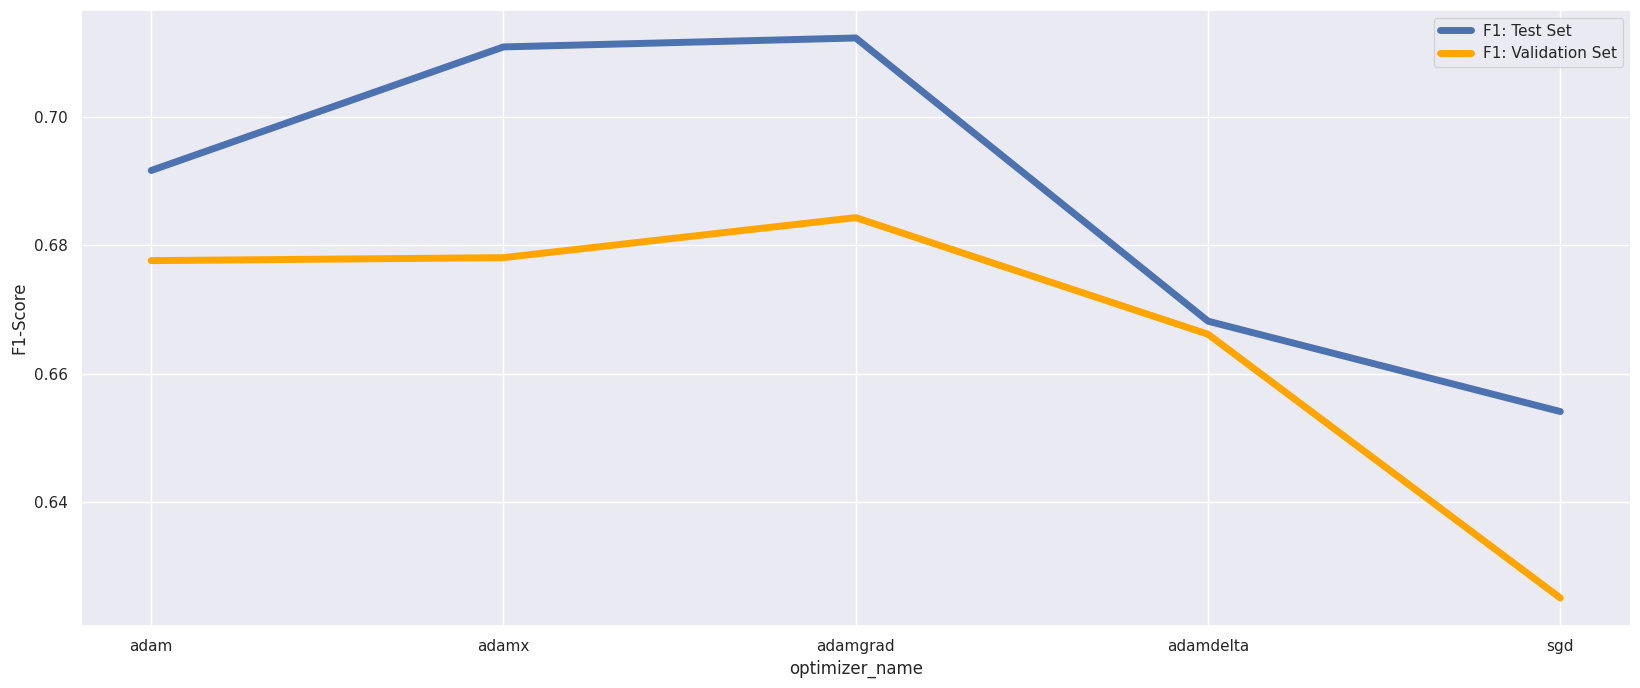

In [16]:
model,best_lr = evaluate_efect_param(parameter_type='model_params',parameter_name='optimizer_name', values_list=['adam','adamx','adamgrad','adamdelta','sgd'])
kfold_params['model_params']['optimizer_name'] = best_lr

## Tuning Learning Rate

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params learning_rate = 1e-05 the training result is:
Val: 1e-05, Validation Score: 0.686, Test Score: 0.711



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params learning_rate = 0.0001 the training result is:
Val: 0.0001, Validation Score: 0.689, Test Score: 0.712



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params learning_rate = 0.001 the training result is:
Val: 0.001, Validation Score: 0.705, Test Score: 0.717



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params learning_rate = 0.01 the training result is:
Val: 0.01, Validation Score: 0.708, Test Score: 0.721



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 1ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params learning_rate = 0.1 the training result is:
Val: 0.1, Validation Score: 0.693, Test Score: 0.705



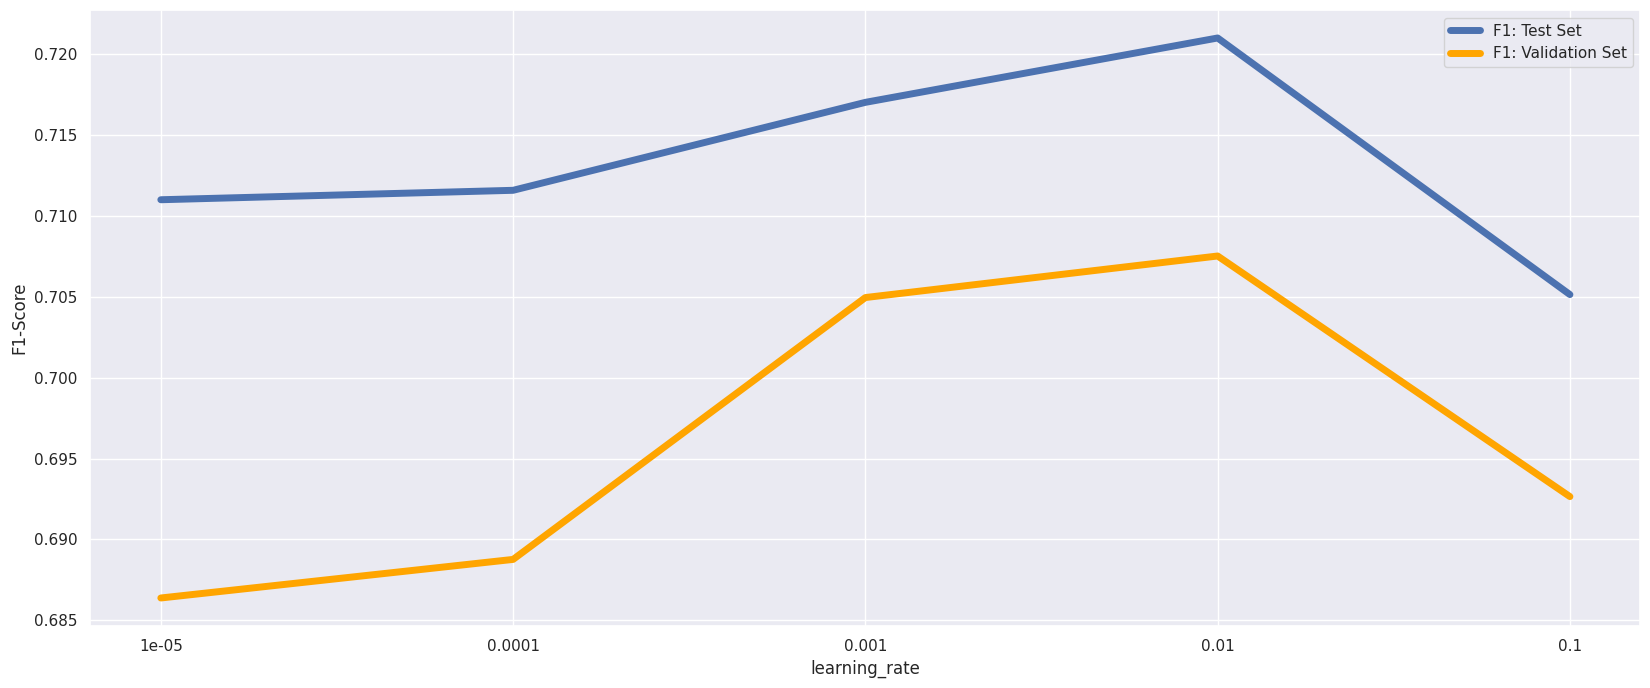

In [17]:
model,best_lr = evaluate_efect_param(parameter_type='model_params',parameter_name='learning_rate', values_list=[0.00001,0.0001,0.001,0.01,0.1])
kfold_params['model_params']['learning_rate'] = best_lr


## Tuning learning rate decay

469/469 [==============================] - 1s 3ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params learning_rate_decay = 0.7 the training result is:
Val: 0.7, Validation Score: 0.691, Test Score: 0.718



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params learning_rate_decay = 0.75 the training result is:
Val: 0.75, Validation Score: 0.696, Test Score: 0.723



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params learning_rate_decay = 0.85 the training result is:
Val: 0.85, Validation Score: 0.693, Test Score: 0.692



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 1ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params learning_rate_decay = 0.9 the training result is:
Val: 0.9, Validation Score: 0.681, Test Score: 0.725



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params learning_rate_decay = 0.95 the training result is:
Val: 0.95, Validation Score: 0.712, Test Score: 0.714



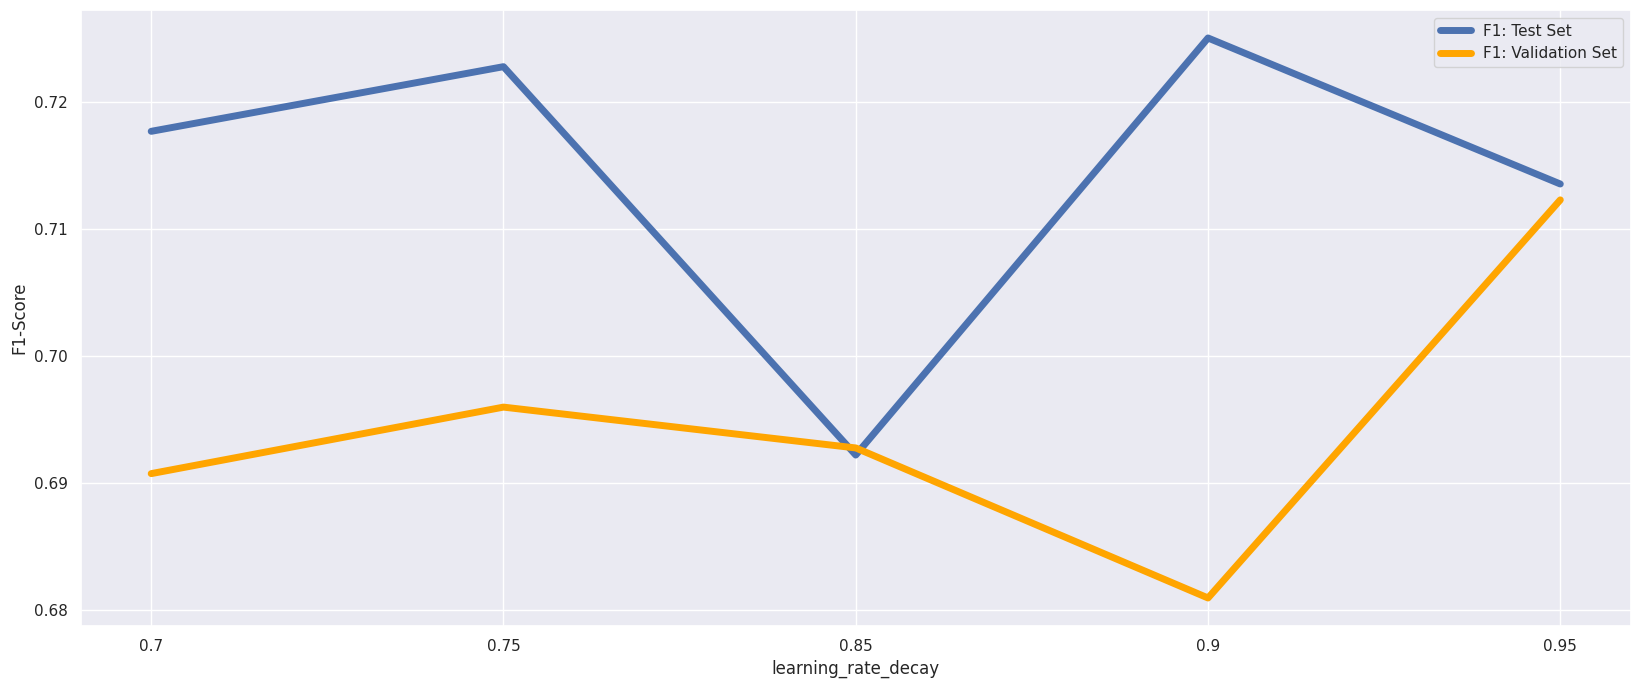

In [22]:
model,best_lr_decay = evaluate_efect_param(parameter_type='model_params',parameter_name='learning_rate_decay', values_list=[0.70,0.75,0.85,0.90,0.95])
kfold_params['model_params']['learning_rate_decay'] = best_lr_decay


## Tuning batch size

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the training_params batch_size = 16 the training result is:
Val: 16, Validation Score: 0.666, Test Score: 0.696



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the training_params batch_size = 32 the training result is:
Val: 32, Validation Score: 0.691, Test Score: 0.716



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the training_params batch_size = 128 the training result is:
Val: 128, Validation Score: 0.714, Test Score: 0.723



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the training_params batch_size = 512 the training result is:
Val: 512, Validation Score: 0.757, Test Score: 0.763



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the training_params batch_size = 1024 the training result is:
Val: 1024, Validation Score: 0.742, Test Score: 0.736



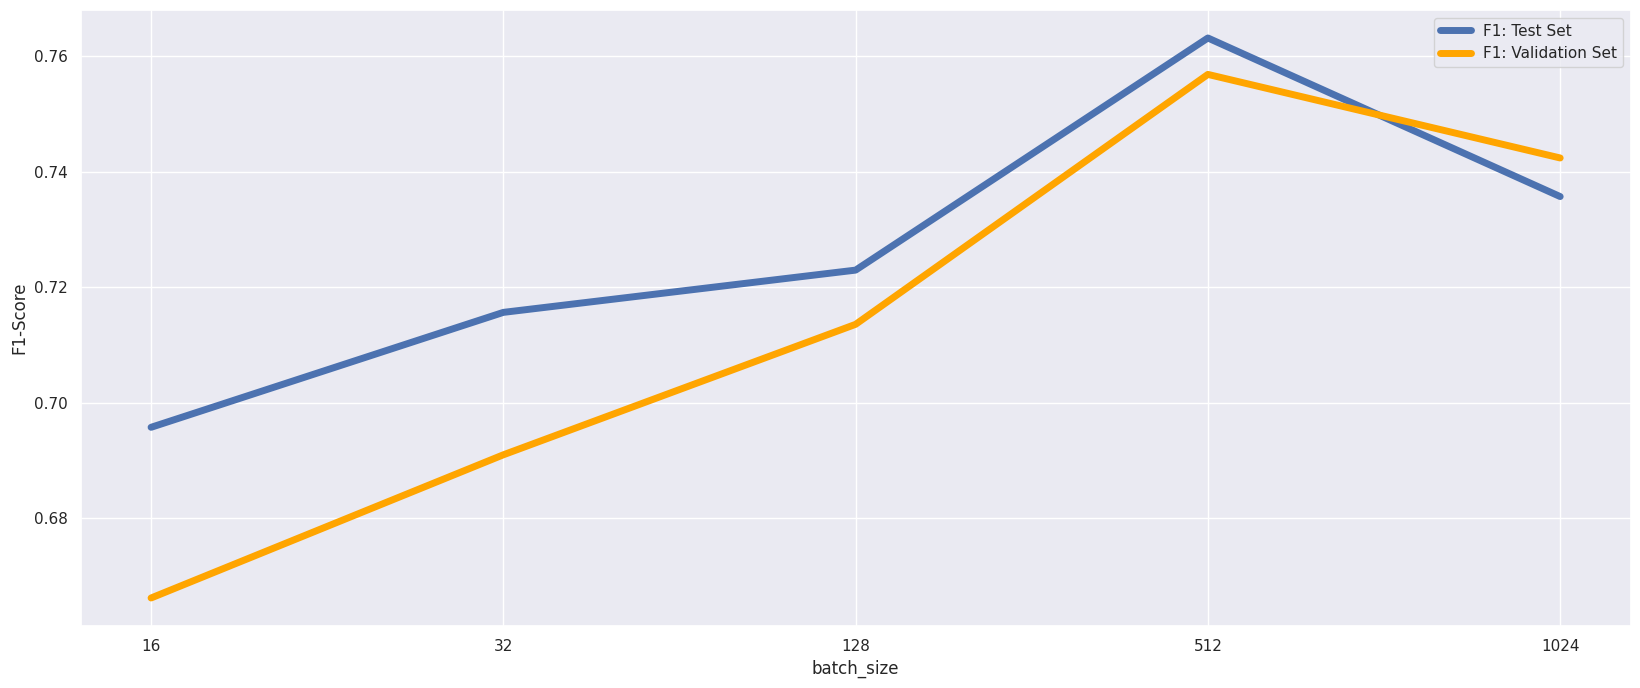

In [23]:
model,best_batch_size = evaluate_efect_param(parameter_type='training_params',parameter_name='batch_size', values_list=[16,32,128,512, 1024])
kfold_params['training_params']['batch_size'] = best_batch_size

## Tuning activation functions

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


For the model_params activation_func = relu the training result is:
Val: relu, Validation Score: 0.645, Test Score: 0.776

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params activation_func = tanh the training result is:
Val: tanh, Validation Score: 0.737, Test Score: 0.754



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 1ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params activation_func = sigmoid the training result is:
Val: sigmoid, Validation Score: 0.748, Test Score: 0.758



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params activation_func = softplus the training result is:
Val: softplus, Validation Score: 0.669, Test Score: 0.735



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params activation_func = softsign the training result is:
Val: softsign, Validation Score: 0.779, Test Score: 0.784



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 3ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params activation_func = selu the training result is:
Val: selu, Validation Score: 0.629, Test Score: 0.766



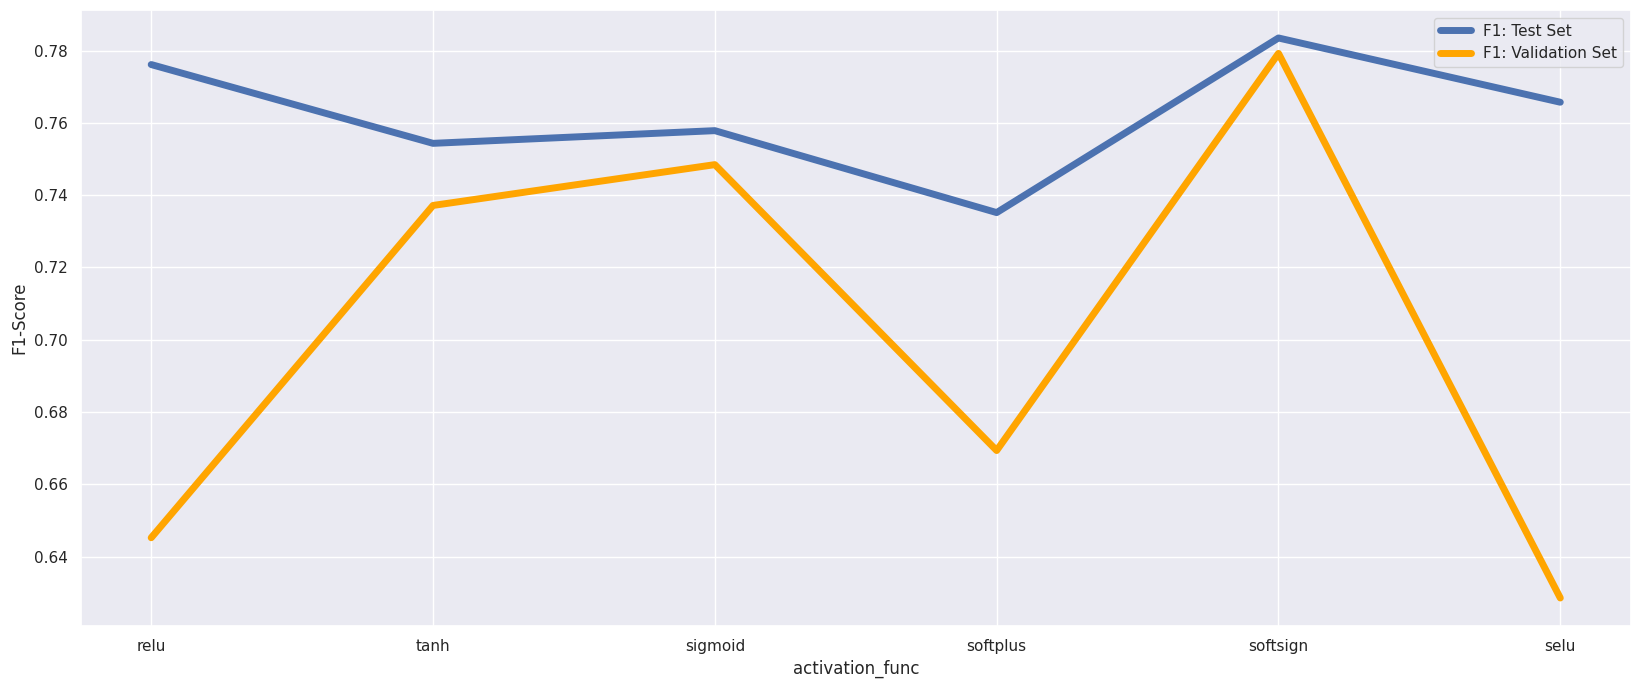

In [24]:
model,best_activation_func = evaluate_efect_param(parameter_type='model_params',parameter_name='activation_func', values_list=['relu','tanh','sigmoid','softplus','softsign','selu'])
kfold_params['model_params']['activation_func'] = best_activation_func

##  Tuning weight intilaization

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params weight_initializer = RandomNormal the training result is:
Val: RandomNormal, Validation Score: 0.784, Test Score: 0.788



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params weight_initializer = RandomUniform the training result is:
Val: RandomUniform, Validation Score: 0.781, Test Score: 0.791



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params weight_initializer = Zeros the training result is:
Val: Zeros, Validation Score: 0.018, Test Score: 0.018



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


For the model_params weight_initializer = GlorotUniform the training result is:
Val: GlorotUniform, Validation Score: 0.770, Test Score: 0.773

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params weight_initializer = GlorotNormal the training result is:
Val: GlorotNormal, Validation Score: 0.775, Test Score: 0.773



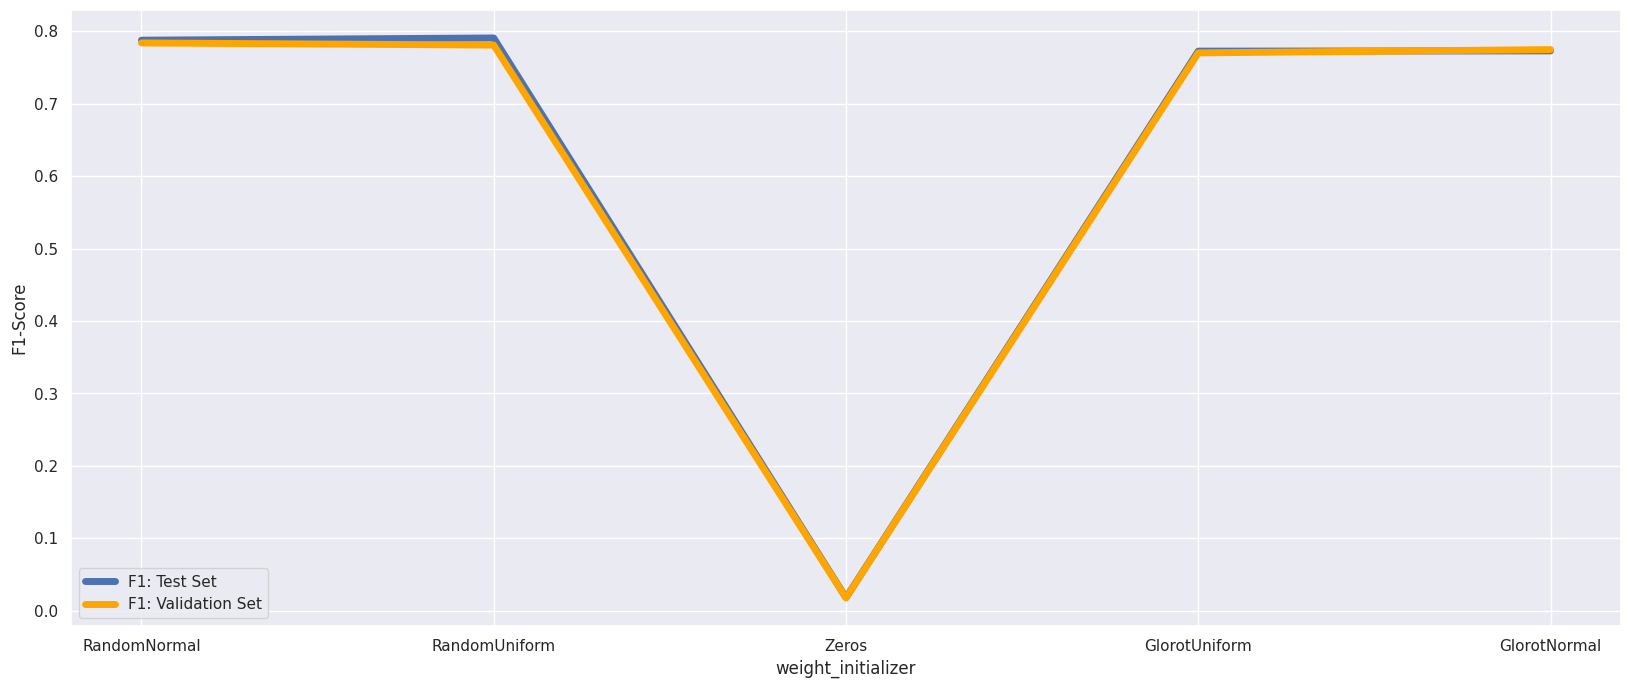

In [25]:
weight_initializers=['RandomNormal','RandomUniform','Zeros','GlorotUniform','GlorotNormal']
model,best_weight_initializer = evaluate_efect_param(parameter_type='model_params',parameter_name='weight_initializer', values_list=weight_initializers)
kfold_params['model_params']['weight_initializer'] = best_weight_initializer

##  Tuning model architecture

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params no_hidden_neurons = [10, 10, 10] the training result is:
Val: [10, 10, 10], Validation Score: 0.565, Test Score: 0.595



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params no_hidden_neurons = [50, 80, 30] the training result is:
Val: [50, 80, 30], Validation Score: 0.783, Test Score: 0.783



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


For the model_params no_hidden_neurons = [300, 100] the training result is:
Val: [300, 100], Validation Score: 0.795, Test Score: 0.799

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params no_hidden_neurons = [30, 30] the training result is:
Val: [30, 30], Validation Score: 0.774, Test Score: 0.775



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params no_hidden_neurons = [200] the training result is:
Val: [200], Validation Score: 0.808, Test Score: 0.805



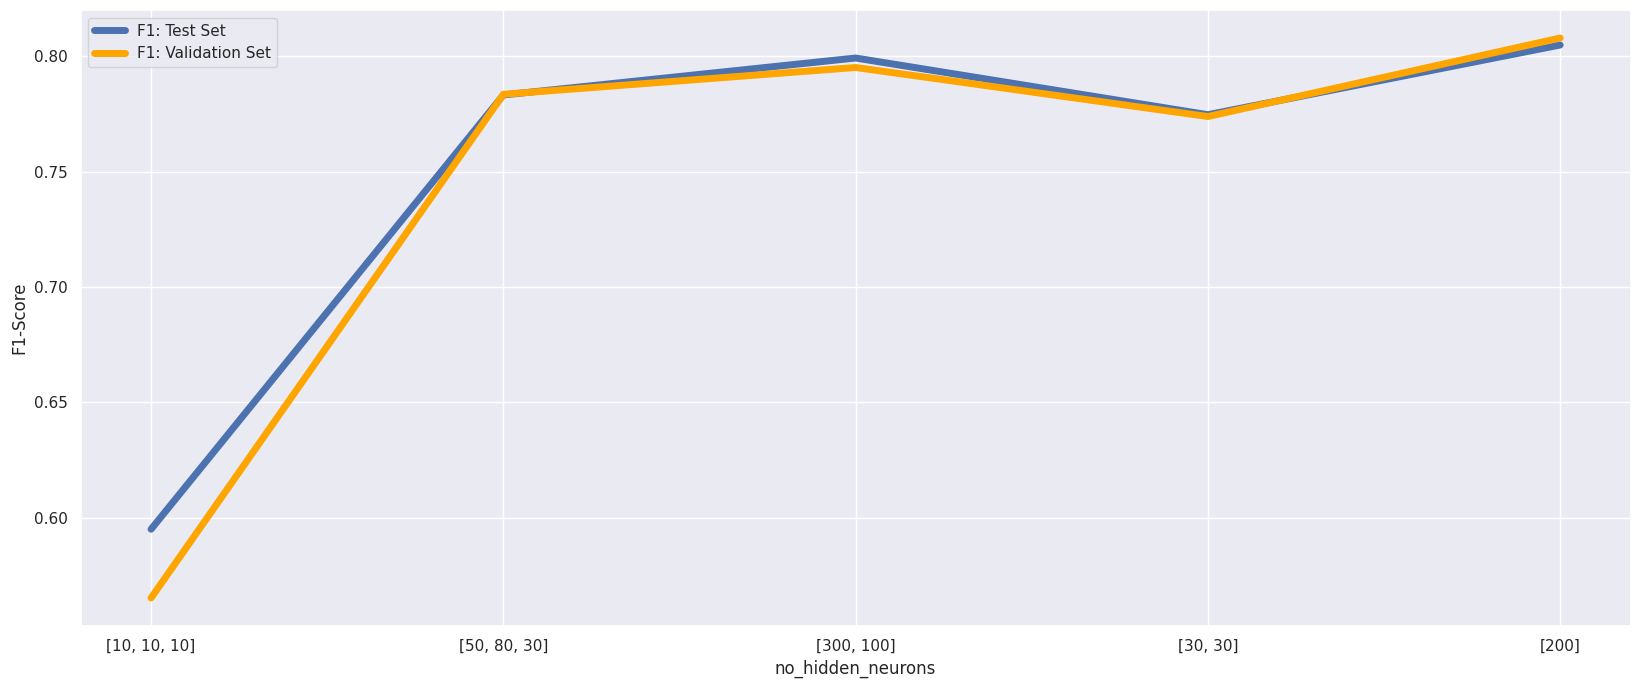

In [26]:
model_arch=[[10,10,10],[50,80,30],[300, 100],[30,30],[200]]
model,best_weight_initializer = evaluate_efect_param(parameter_type='model_params',parameter_name='no_hidden_neurons', values_list=model_arch)
kfold_params['model_params']['no_hidden_neurons'] = best_weight_initializer

## Tuning l1 and l2 regularization in the weights

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l1_reg = 0 the training result is:
Val: 0, Validation Score: 0.814, Test Score: 0.801



469/469 [==============================] - 1s 1ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l1_reg = 1e-05 the training result is:
Val: 1e-05, Validation Score: 0.804, Test Score: 0.791



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 1ms/step


313/313 [==============================] - 1s 2ms/step


For the model_params l1_reg = 0.0001 the training result is:
Val: 0.0001, Validation Score: 0.802, Test Score: 0.799

469/469 [==============================] - 1s 1ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 1ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l1_reg = 0.001 the training result is:
Val: 0.001, Validation Score: 0.791, Test Score: 0.784



469/469 [==============================] - 1s 1ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l1_reg = 0.01 the training result is:
Val: 0.01, Validation Score: 0.775, Test Score: 0.782



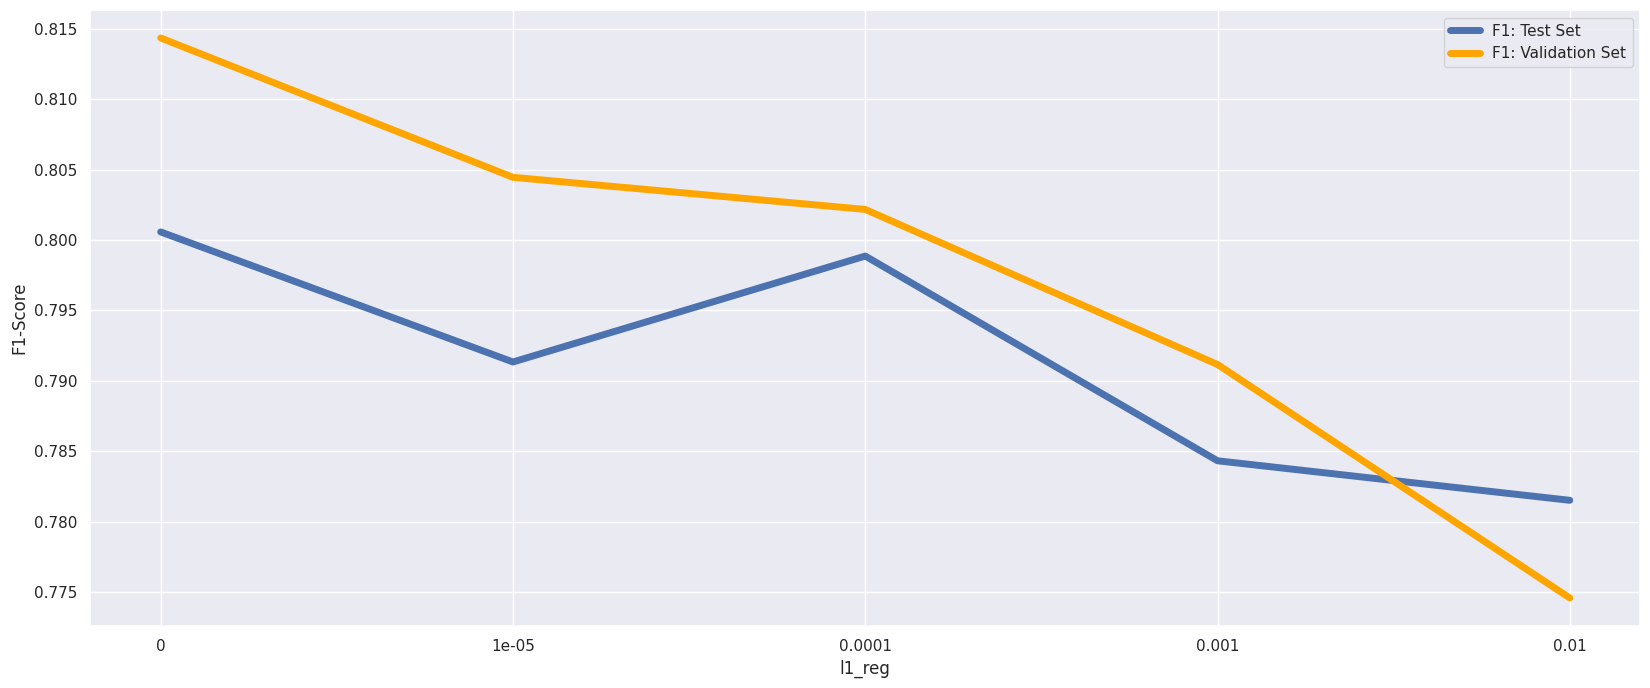

In [27]:
# L1
model,best_l1_reg = evaluate_efect_param(parameter_type='model_params',parameter_name='l1_reg', values_list=[0, 0.00001,0.0001,0.001,0.01])
kfold_params['model_params']['l1_reg'] = best_l1_reg

In [31]:
kfold_params = {
    'no_folds': 4,
    'plot_results': False,
    'model_params': {
      'no_hidden_neurons': [300,100],
      'activation_func': 'softsign',
      'l1_reg': 0,
      'l2_reg': 0,
      'learning_rate': 0.0001,
      'learning_rate_decay': 0.9,
      'dropout_rate':0,
      'weight_initializer': 'RandomUniform',
      'optimizer_name': 'adamdelta',
      'regularization_type': 'kernel',
  },
  'training_params': {
    'batch_size': 256,
    'epochs': 2
  }
}

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l2_reg = 0 the training result is:
Val: 0, Validation Score: 0.702, Test Score: 0.704



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l2_reg = 1e-05 the training result is:
Val: 1e-05, Validation Score: 0.676, Test Score: 0.720



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params l2_reg = 0.0001 the training result is:
Val: 0.0001, Validation Score: 0.678, Test Score: 0.698



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l2_reg = 0.001 the training result is:
Val: 0.001, Validation Score: 0.681, Test Score: 0.689



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 1ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l2_reg = 0.01 the training result is:
Val: 0.01, Validation Score: 0.663, Test Score: 0.691



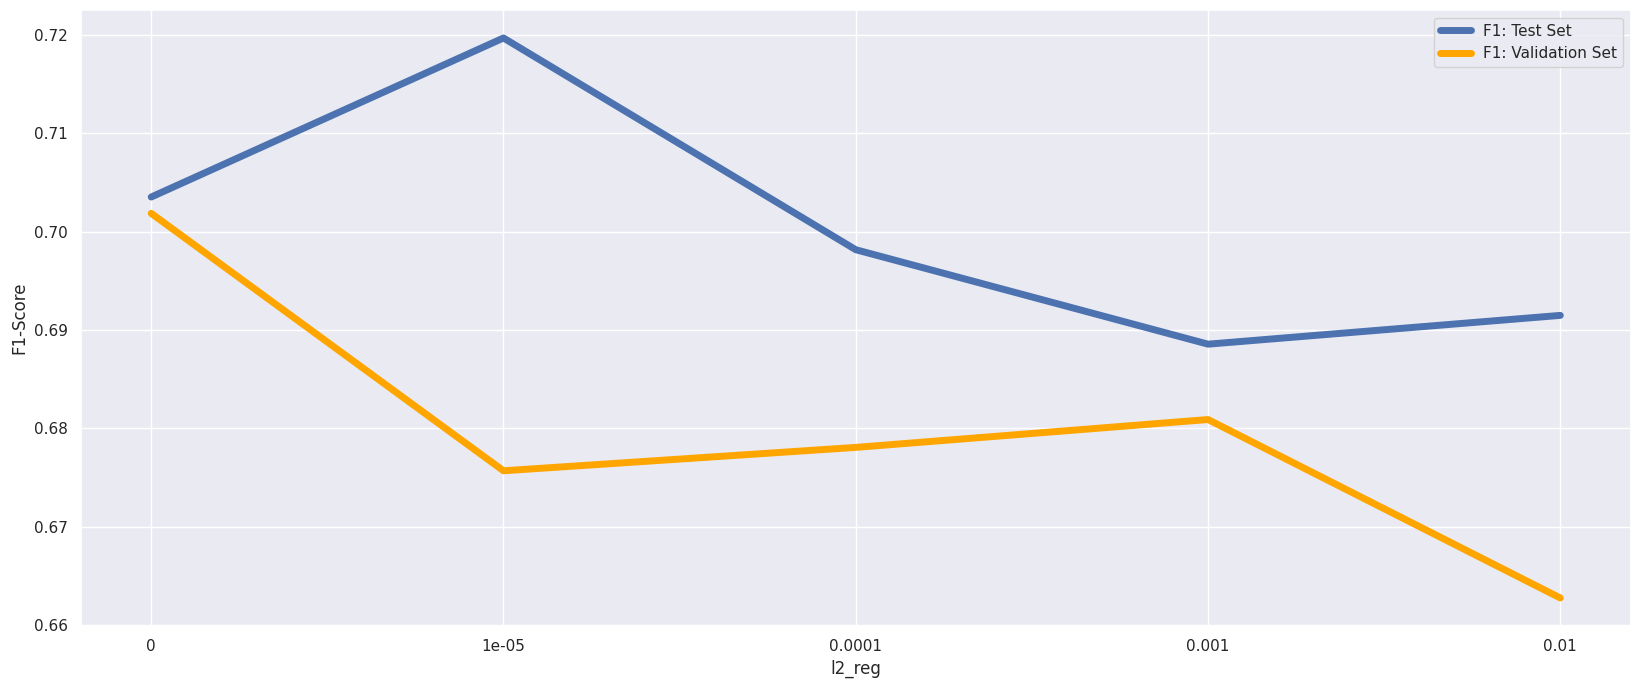

In [29]:
# L2
model,best_l2_reg = evaluate_efect_param(parameter_type='model_params',parameter_name='l2_reg', values_list=[0, 0.00001,0.0001,0.001,0.01])
kfold_params['model_params']['l2_reg'] = best_l2_reg

## Tuning l1 and l2 regularization in the activity_kernel

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l1_reg = 1e-05 the training result is:
Val: 1e-05, Validation Score: 0.737, Test Score: 0.746



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l1_reg = 0.0001 the training result is:
Val: 0.0001, Validation Score: 0.756, Test Score: 0.754



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l1_reg = 0.001 the training result is:
Val: 0.001, Validation Score: 0.760, Test Score: 0.766



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l1_reg = 0.01 the training result is:
Val: 0.01, Validation Score: 0.765, Test Score: 0.770



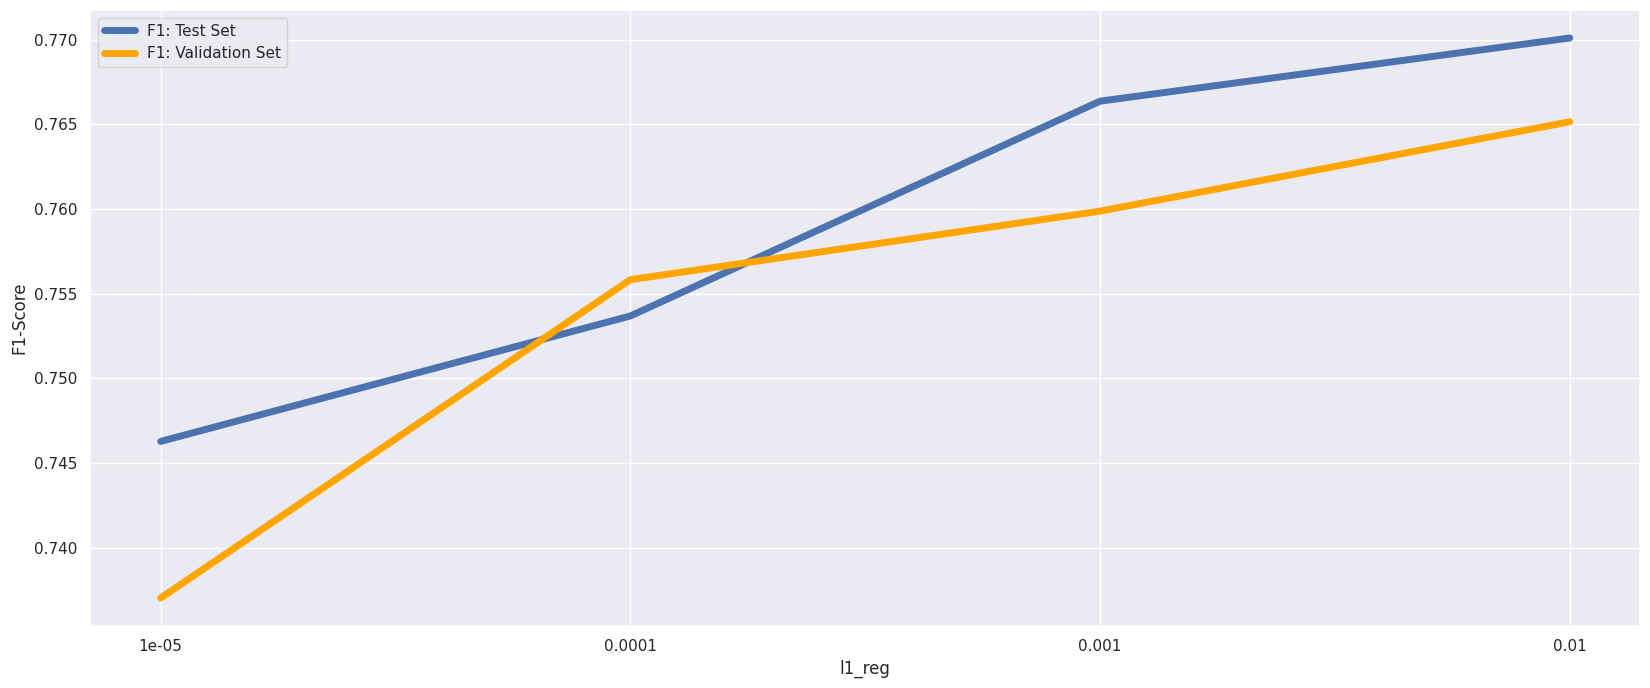

In [32]:
# L1
kfold_params['model_params']['regularization_type'] = 'activation'
model,best_l1_reg = evaluate_efect_param(parameter_type='model_params',parameter_name='l1_reg', values_list=[0.00001,0.0001,0.001,0.01])
kfold_params['model_params']['l1_reg'] = best_l1_reg

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l2_reg = 0 the training result is:
Val: 0, Validation Score: 0.753, Test Score: 0.762



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l2_reg = 1e-05 the training result is:
Val: 1e-05, Validation Score: 0.733, Test Score: 0.760



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params l2_reg = 0.0001 the training result is:
Val: 0.0001, Validation Score: 0.744, Test Score: 0.740



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params l2_reg = 0.001 the training result is:
Val: 0.001, Validation Score: 0.748, Test Score: 0.754



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params l2_reg = 0.01 the training result is:
Val: 0.01, Validation Score: 0.745, Test Score: 0.750



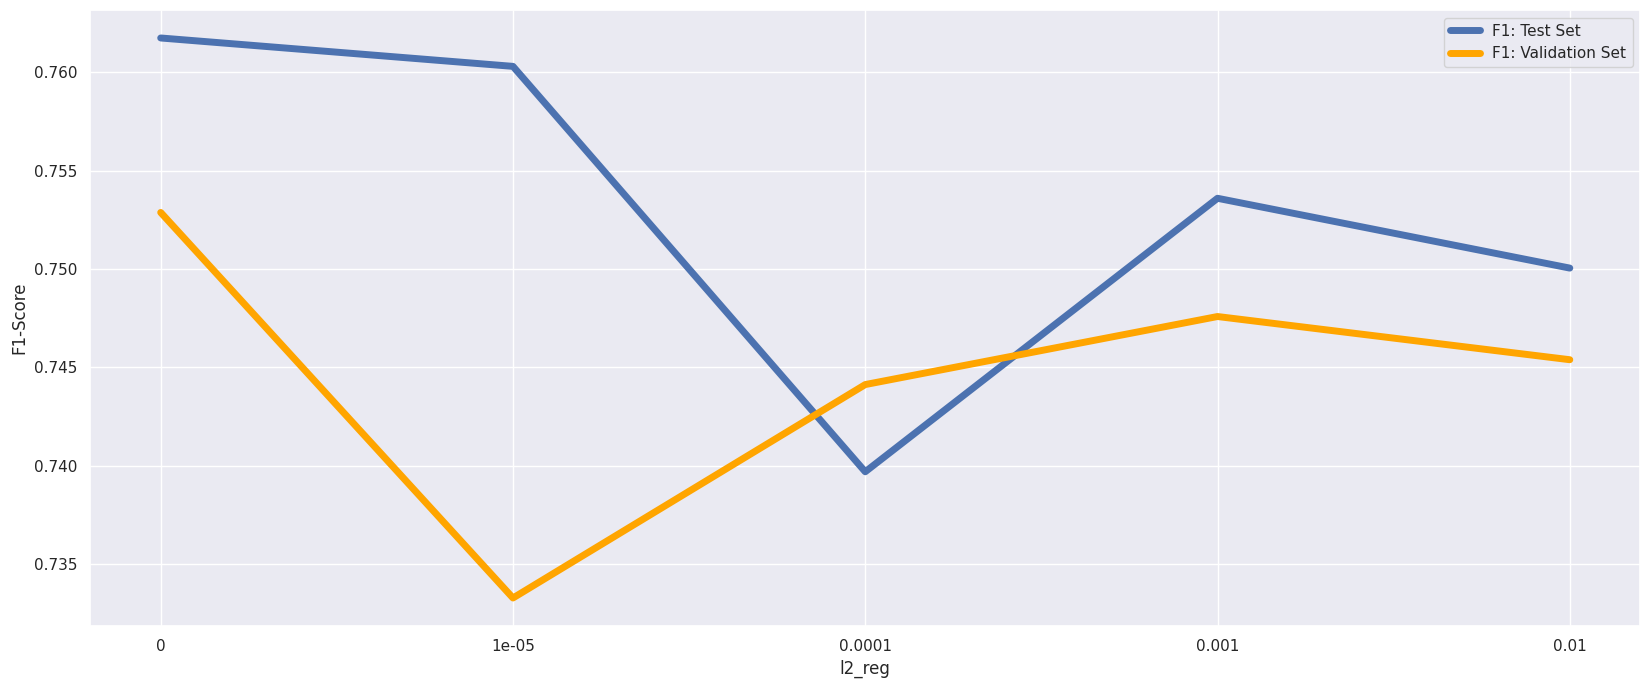

In [33]:
# L2
model,best_l2_reg = evaluate_efect_param(parameter_type='model_params',parameter_name='l2_reg', values_list=[0, 0.00001,0.0001,0.001,0.01])
kfold_params['model_params']['l2_reg'] = best_l2_reg

## Tuning dropout rate

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params dropout_rate = 0 the training result is:
Val: 0, Validation Score: 0.750, Test Score: 0.760



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params dropout_rate = 0.0001 the training result is:
Val: 0.0001, Validation Score: 0.728, Test Score: 0.744



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


For the model_params dropout_rate = 0.01 the training result is:
Val: 0.01, Validation Score: 0.747, Test Score: 0.748

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params dropout_rate = 0.1 the training result is:
Val: 0.1, Validation Score: 0.752, Test Score: 0.768



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params dropout_rate = 0.3 the training result is:
Val: 0.3, Validation Score: 0.748, Test Score: 0.759



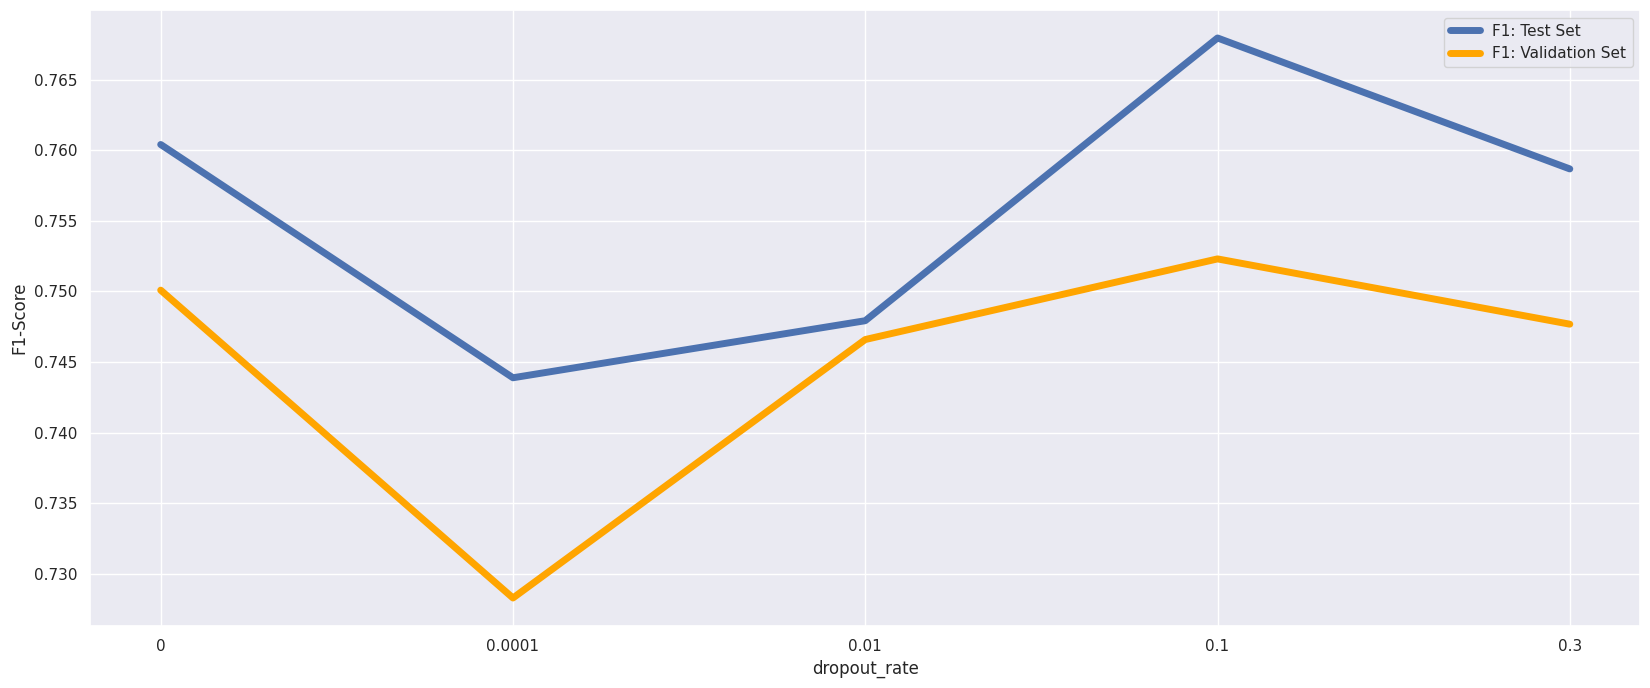

In [34]:
model,best_dropout_rate = evaluate_efect_param(parameter_type='model_params',parameter_name='dropout_rate', values_list=[0, 0.0001,0.01,0.1,0.3])
kfold_params['model_params']['dropout_rate'] = best_dropout_rate

469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 1ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params no_hidden_neurons = [10] the training result is:
Val: [10], Validation Score: 0.674, Test Score: 0.690



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params no_hidden_neurons = [30, 10] the training result is:
Val: [30, 10], Validation Score: 0.706, Test Score: 0.731



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params no_hidden_neurons = [20, 10, 6] the training result is:
Val: [20, 10, 6], Validation Score: 0.330, Test Score: 0.416



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step
For the model_params no_hidden_neurons = [10, 2] the training result is:
Val: [10, 2], Validation Score: 0.180, Test Score: 0.267



469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


469/469 [==============================] - 1s 2ms/step


313/313 [==============================] - 0s 2ms/step
For the model_params no_hidden_neurons = [100] the training result is:
Val: [100], Validation Score: 0.766, Test Score: 0.771



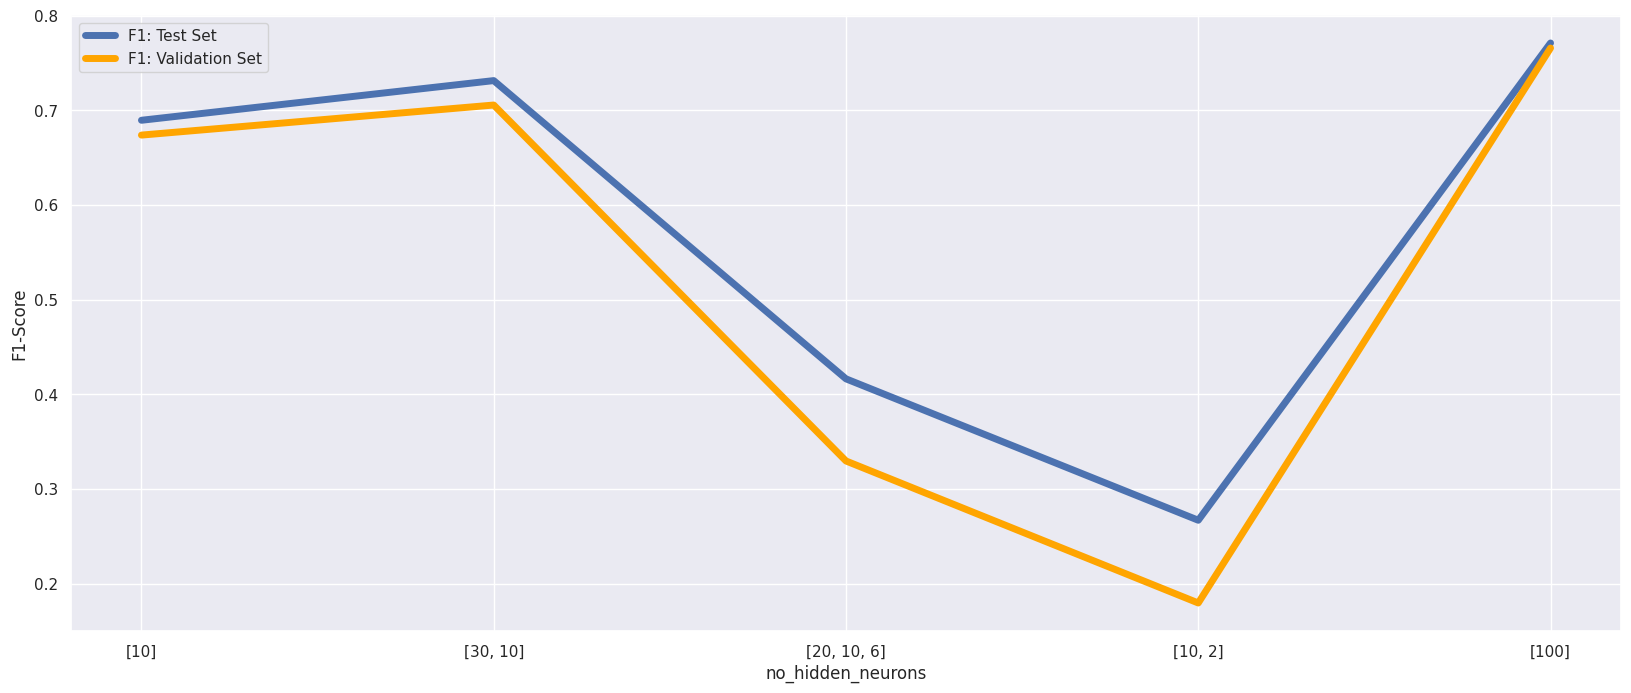

In [35]:
model,best_architecture = evaluate_efect_param(parameter_type='model_params',parameter_name='no_hidden_neurons',values_list=[[10],[30,10],[20,10,6], [10,2], [100]])
kfold_params['model_params']['no_hidden_neurons'] = best_architecture

# In a paragraph, explain why it gets more difficult to train deep neural networks when the number of layers increase (i.e. when the network gets deeper).

Deepening neural networks, by adding more layers, introduces several challenges that make the training process more complex. Firstly, the number of parameters in the network increases exponentially with each added layer, leading to a larger optimization problem. Secondly, the gradients of the loss function become more diluted and unstable as they propagate through the deeper network, making it harder for the optimizer to efficiently update the parameters. Additionally, the network becomes more prone to overfitting, as it has more opportunities to memorize training data rather than generalizing to unseen examples. These challenges require careful design of the network architecture, optimization algorithms, and regularization techniques to ensure effective training and prevent the model from becoming too complex or overfitting to the training data.